# DNN Hyperparameter Search - Analysis
### This notebook documents the analysis of the hyperparamter search

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer
from sklearn.model_selection import StratifiedKFold
import annsa as an
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from random import choice
import glob

import pandas as pd
import seaborn as sns

In [2]:
def read_final_errors(file_path, *args): 

    final_errors = []
    for model_id in args:
        final_errors = np.append(final_errors, np.load(file_path+model_id+'.npy'))
    return final_errors


In [210]:
class all_dnn_features_class(object):

    def __init__(self,
                 dropout_probability,
                 batch_size,
                 learining_rate,
                 dense_nodes,
                 activation_function,
                 l2_regularization_scale,
                 dense_nodes_length,
                 dense_nodes_total,
                 normalizer,
                 scaling,
                 ):
        self.dropout_probability = dropout_probability,
        self.batch_size = batch_size
        self.learning_rate = learining_rate
        self.dense_nodes = dense_nodes
        self.activation_function = activation_function
        self.l2_regularization_scale = l2_regularization_scale
        self.normalizer = normalizer
        self.scaling = scaling
        self.dense_nodes_length = dense_nodes_length
        self.dense_nodes_total = dense_nodes_total

    def to_dict(self):
        '''
        Returns a dictionary of the class parameters.
        '''
        return {
            'dropout_probability': self.dropout_probability[0],
            'batch_size': self.batch_size,
            'learning_rate': self.learning_rate,
            'dense_nodes': self.dense_nodes,
            'activation_function': self.activation_function,
            'l2_regularization_scale': self.l2_regularization_scale,
            'normalizer': self.normalizer,
            'scaling': self.scaling,
            'dense_nodes_length': self.dense_nodes_length,
            'dense_nodes_total': self.dense_nodes_total,
        }

In [211]:
def read_errors_and_features(file_path_errors, model_id, *args):

    all_errors = read_final_errors(file_path_errors, *args)

    dropout_probability = []
    batch_size = []
    learining_rate = []
    dense_nodes = []
    activation_function = []
    l2_regularization_scale = []
    scaling = []
    normalizer = []
    
    for j in range(len(args)):
        total_errors = len(np.load(file_path_errors+args[j]+'.npy'))
        j = '-'+str(j)
        total_models = len(glob.glob('../hyperparameter_search/hyperparameter-search-results/'+model_id+j+'*'))
        
        for i in range(0, total_errors):

            i = '_'+str(i)

            with open('../hyperparameter_search/hyperparameter-search-results/'+model_id+j+i+'_dae_features',"rb" ) as f:

                model_features = pickle.load(f)
                scaling_tmp, normalizer_tmp = read_scaler_pipeline(model_features.scaler)
                
                scaling.append(scaling_tmp)
                normalizer.append(normalizer_tmp)
                learining_rate.append(model_features.learining_rate)
                dropout_probability.append(model_features.dropout_probability)
                batch_size.append(model_features.batch_size)
                dense_nodes.append(model_features.dense_nodes)
                activation_function.append(model_features.activation_function)
                l2_regularization_scale.append(model_features.l2_regularization_scale)


    for i in range(len(activation_function)):
        if 'relu' in str(activation_function[i]):
            activation_function[i] = 'relu'
        if 'sigmoid' in str(activation_function[i]):
            activation_function[i] = 'sigmoid'
        if 'tanh' in str(activation_function[i]):
            activation_function[i] = 'tanh'

    dense_nodes_length = [len(feature) for feature in dense_nodes]
    dense_nodes_total = [sum(feature) for feature in dense_nodes]

    all_features = all_dnn_features_class(dropout_probability,
                                          batch_size,
                                          learining_rate,
                                          dense_nodes,
                                          activation_function,
                                          l2_regularization_scale,
                                          dense_nodes_length,
                                          dense_nodes_total,
                                          normalizer,
                                          scaling,)

    return all_errors, all_features


In [212]:
def read_scaler_pipeline(scaler):
    
    scaling = scaler.named_steps['functiontransformer'].func.__name__
    
    normalizer = 'None'    
    if scaler.named_steps.get('normalizer'):
        normalizer = scaler.named_steps['normalizer'].norm

    return scaling, normalizer


## Load easy errors

In [213]:
file_path_errors = '../hyperparameter_search/final-models/final_test_errors_'

In [59]:
data_strings_easy = ['DNN-kfoldseasy-final-'+str(x) for x in range(10)]

In [60]:
dnn_errors_easy, all_features_easy = read_errors_and_features(file_path_errors,
                                                              'DNN-kfoldseasy-final',
                                                              *data_strings_easy,
                                                              )

In [215]:
dataframe_easy = pd.DataFrame(all_features_easy.to_dict())
tmp_dataframe = pd.DataFrame(dnn_errors_easy, columns=['F1 Error'])
dataframe_easy = tmp_dataframe.join(dataframe_easy)
tmp_dataframe = pd.DataFrame(['Simple']*len(dataframe_easy), columns=['mode'])
dataframe_easy = tmp_dataframe.join(dataframe_easy)

## Load full errors

In [61]:
data_strings_full = ['DNN-kfoldsfull-final-'+str(x) for x in range(10)]

In [62]:
dnn_errors_full, all_features_full = read_errors_and_features(file_path_errors,
                                                              'DNN-kfoldsfull-final',
                                                              *data_strings_full,
                                                              )       

In [214]:
dataframe_full = pd.DataFrame(all_features_full.to_dict())
tmp_dataframe = pd.DataFrame(dnn_errors_full, columns=['F1 Error'])
dataframe_full = tmp_dataframe.join(dataframe_full)
tmp_dataframe = pd.DataFrame(['Complete']*len(dataframe_full), columns=['mode'])
dataframe_full = tmp_dataframe.join(dataframe_full)

## Combine errors into one dataframe

In [216]:
dataframe_errors = pd.concat([dataframe_easy, dataframe_full], axis=0)

### Set plot parameters

In [226]:
sns.set(font_scale=1.5)  # crazy big
sns.set_style("white")

# Batch size

Text(0.5, 0, 'Batch Size')

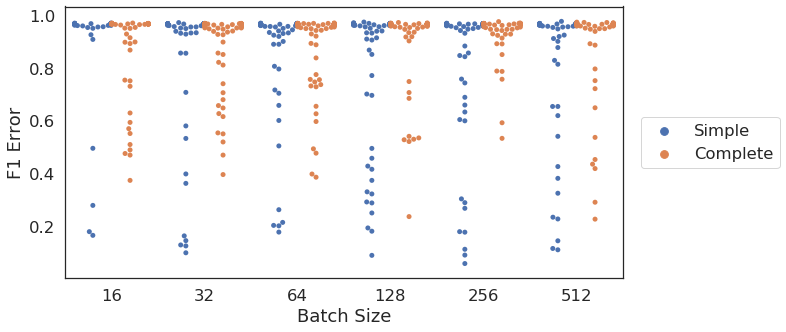

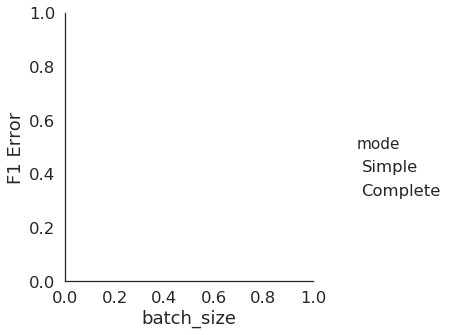

In [236]:
fig, ax = plt.subplots(figsize=(10,5))

_ = sns.catplot(ax=ax, x='batch_size', y='F1 Error', hue='mode',  data=dataframe_errors,
                orient = 'v', kind="swarm", dodge=True, legend_out=True,)

ax.legend(loc=5, borderaxespad=-9.5)

ax.set_xlabel("Batch Size", fontsize=18)
# ax.set_ylabel("Y Label", fontsize=20)
# ax.tick_params(labelsize=5)


# Learning Rate

KeyboardInterrupt: 

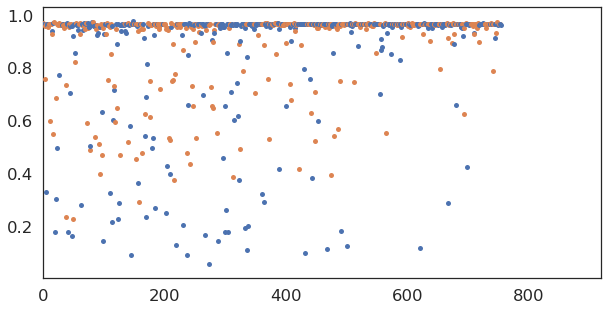

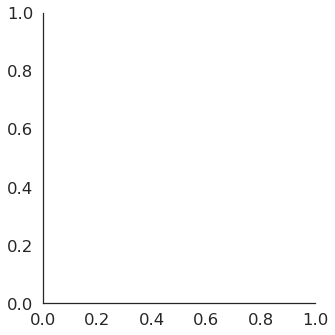

In [239]:
fig, ax = plt.subplots(figsize=(10,5))

_ = sns.catplot(ax=ax, x='learning_rate', y='F1 Error', hue='mode',  data=dataframe_errors,
                orient = 'v', kind="swarm", dodge=True, legend_out=True,)

ax.legend(loc=5, borderaxespad=-9.5)

ax.set_xlabel("Learning Rate", fontsize=18)
# ax.set_ylabel("Y Label", fontsize=20)
# ax.tick_params(labelsize=5)


In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(dnn_errors_easy, np.log10(all_features_easy.learining_rate), c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(dnn_errors_full, np.log10(all_features_full.learining_rate), c='g', alpha=alpha, s=1.5*size, marker='x', linewidth=linewidth)
plt.ylabel('learning rate')
plt.xlabel('F1 Error')

# recommend below 1e-2

# Dropout probability

In [ ]:
plt.figure(figsize=(8,5))

plt.scatter(dnn_errors_easy, all_features_easy.dropout_probability, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(dnn_errors_full, all_features_full.dropout_probability, c='g', alpha=alpha, s=1.5*size, marker='x', linewidth=linewidth)

plt.ylabel('dropout_probability')
plt.xlabel('F1 Error')

# recommend below 0.4

# Number of Layers

In [ ]:
plt.figure(figsize=(8,5))

plt.scatter(dnn_errors_easy, all_features_easy.dense_nodes_length, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(dnn_errors_full, all_features_full.dense_nodes_length, c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)


plt.ylabel('dense_nodes_length')
plt.xlabel('F1 Error')

# More layers for the simple and full dataset do not help. Likely best to stick to one or two layers. 

# Total nodes

In [ ]:
plt.figure(figsize=(8,5))

plt.scatter(dnn_errors_easy, all_features_easy.dense_nodes_total, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(dnn_errors_full, all_features_full.dense_nodes_total, c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('dense_nodes_length')
plt.xlabel('F1 Error')

# No comment.

In [ ]:
plt.figure(figsize=(8,5))

plt.scatter(dnn_errors_easy, all_features_easy.activation_function, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(dnn_errors_full, all_features_full.activation_function, c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('pool_strides_length')
plt.xlabel('F1 Error')

# No comment.

# L2 regularization

In [ ]:
plt.figure(figsize=(8,5))

plt.scatter(dnn_errors_easy, np.log10(all_features_easy.l2_regularization_scale), c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(dnn_errors_full, np.log10(all_features_full.l2_regularization_scale), c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('l2_regularization_scale')
plt.xlabel('F1 Error')

# No comment.

# Normalizer and Scaler

In [ ]:
plt.figure(figsize=(8,5))

plt.scatter(dnn_errors_easy, all_features_easy.normalizer, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(dnn_errors_full, all_features_full.normalizer, c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('pool_strides_length')
plt.xlabel('F1 Error')

In [ ]:
plt.figure(figsize=(8,5))

plt.scatter(dnn_errors_easy, all_features_easy.scaling, c='b', alpha=alpha, s=size, linewidth=linewidth)
plt.scatter(dnn_errors_full, all_features_full.scaling, c='g', alpha=alpha, s=2.5*size, marker='x', linewidth=linewidth)

plt.ylabel('pool_strides_length')
plt.xlabel('F1 Error')

In [ ]:
plt.figure(figsize=(8,5))

plt.scatter(dnn_errors_easy,
            [x+' '+y for x, y in zip(all_features_easy.scaling, all_features_easy.normalizer)],
            c='b',
            alpha=alpha,
            s=size,
            linewidth=linewidth)

plt.scatter(dnn_errors_full,
            [x+' '+y for x, y in zip(all_features_full.scaling, all_features_full.normalizer)],
            c='g',
            alpha=alpha,
            s=2.5*size,
            marker='x',
            linewidth=linewidth)

plt.ylabel('pool_strides_length')
plt.xlabel('F1 Error')

# L1 norm should be avoided. This is likely due to numerical problems when dealing with the small numbers generated by 
# this method. Best method is just to take the sqrt of the counts.